<a href="https://colab.research.google.com/github/alokmishra1210/LSTMStock_Prediction/blob/main/LSTMStock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yfinance

     |████████████████████████████████| 62 kB 697 kB/s 


In [2]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader

import yfinance as yf

import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

import altair as alt 
from altair import datum

import numpy as np 
from datetime import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN', 'DELL', 'INTC', 'NVDA', 'AMD', 'PYPL', 'EBAY']

#Import from API
end = dt.now()
start = dt(end.year - 4, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

number_of_days = end - start
us_bd = np.busdaycalendar
datelist_past = pd.date_range(start, end, freq='C').tolist()    

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN, DELL, INTC, NVDA, AMD, PYPL, EBAY]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "DELL", "INTEL", "NVIDIA", "AMD", "PAYPAL", "EBAY"]

#Make date part of dataset
for stock in stocks:
  stock["Date"] = stock.index
  stock = stock[["Date", "Open", "High", 
              "Low", "Close", "Adj Close", "Volume"]]
  stock.reset_index(drop=True, inplace=True)
  print(stock.head(2))

#Additional Columns
for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()
    stock['volumeChange'] = stock.Volume.pct_change() 
    stock['weekday_num'] = pd.DatetimeIndex(stock['Date']).weekday
    stock['month'] = pd.DatetimeIndex(stock['Date']).month
    stock['day'] = pd.DatetimeIndex(stock['Date']).day
    stock['year'] = pd.DatetimeIndex(stock['Date']).year
    stock['display'] = stock["month"].map(str)+ "-" + stock["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

#Forcasting Stock
stockDf = stocks[3] #AAPL

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        Date       Open       High        Low      Close  Adj Close    Volume
0 2018-08-14  71.690002  71.839996  69.419998  69.528000  69.528000  34932000
1 2018-08-15  68.382004  68.898003  66.428001  67.737999  67.737999  45506500
       

In [4]:
stocks[2].head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2018-08-14  61.759499  62.293499  61.255501  62.105000  62.105000  26962000   
2018-08-15  61.463001  61.762001  60.475498  60.719002  60.719002  36576000   
2018-08-16  61.236500  61.299999  60.127499  60.324501  60.324501  26864000   
2018-08-17  60.101501  60.451000  59.411999  60.048000  60.048000  27792000   
2018-08-20  60.250999  60.549999  59.731300  60.388500  60.388500  17416000   

                 Date company_name  openChange  closeChange  volumeChange  \
Date                                                                        
2018-08-14 2018-08-14       GOOGLE         NaN          NaN           NaN   
2018-08-15 2018-08-15       GOOGLE   -0.004801    -0.022317      0.356576   
2018-08-16 2018-08-16       GOOGLE   -0.003685    -0.006497     -0.265529   
2018-08-17 2018-08-17       GOOGLE   -0.018535    -0.004584      0.034544   
2018-08-20 2018-08-20       GOOGLE    0.002487     0.005670     -0.373345   

            weekday_num  month  day  year display  
Date                                               
2018-08-14            1      8   14  2018  8-2018  
2018-08-15            2      8   15  2018  8-2018  
2018-08-16            3      8   16  2018  8-2018  
2018-08-17            4      8   17  2018  8-2018  
2018-08-20            0      8   20  2018  8-2018

In [5]:
DELL.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2018-08-14  26.408564  26.652723  26.329985  26.621853  26.233307  2663877   
2018-08-15  26.503983  26.677982  26.380501  26.571339  26.183531  4963947   
2018-08-16  26.837950  26.950207  26.621853  26.823917  26.432423  5335949   
2018-08-17  26.736917  26.908110  26.630274  26.663950  26.274790  2978154   
2018-08-20  26.675177  26.779015  26.610628  26.669563  26.280321  4022896   

                 Date company_name  openChange  closeChange  volumeChange  \
Date                                                                        
2018-08-14 2018-08-14         DELL         NaN          NaN           NaN   
2018-08-15 2018-08-15         DELL    0.003613    -0.001897      0.863430   
2018-08-16 2018-08-16         DELL    0.012601     0.009506      0.074941   
2018-08-17 2018-08-17         DELL   -0.003765    -0.005964     -0.441870   
2018-08-20 2018-08-20         DELL   -0.002309     0.000211      0.350802   

            weekday_num  month  day  year display  
Date                                               
2018-08-14            1      8   14  2018  8-2018  
2018-08-15            2      8   15  2018  8-2018  
2018-08-16            3      8   16  2018  8-2018  
2018-08-17            4      8   17  2018  8-2018  
2018-08-20            0      8   20  2018  8-2018

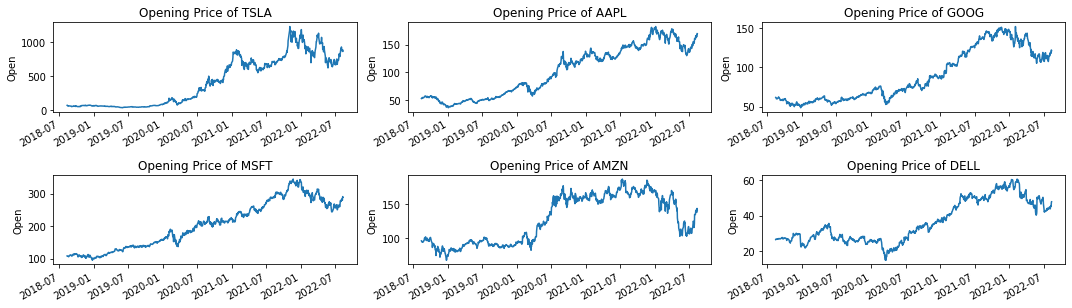

In [6]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(3, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

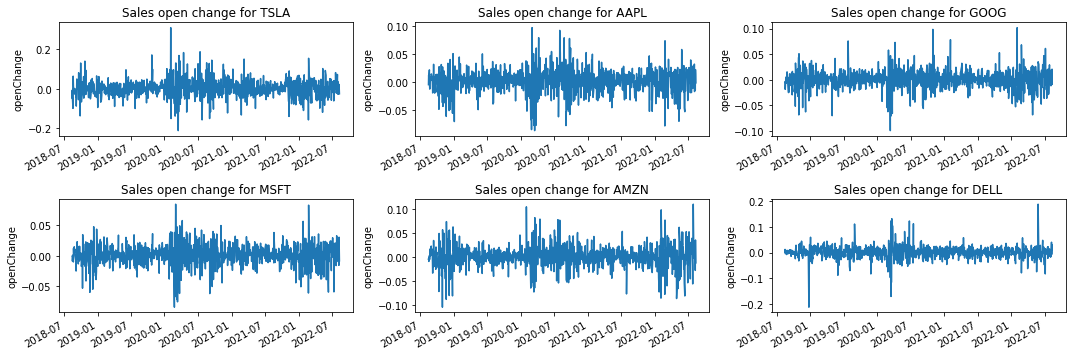

In [7]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(3, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

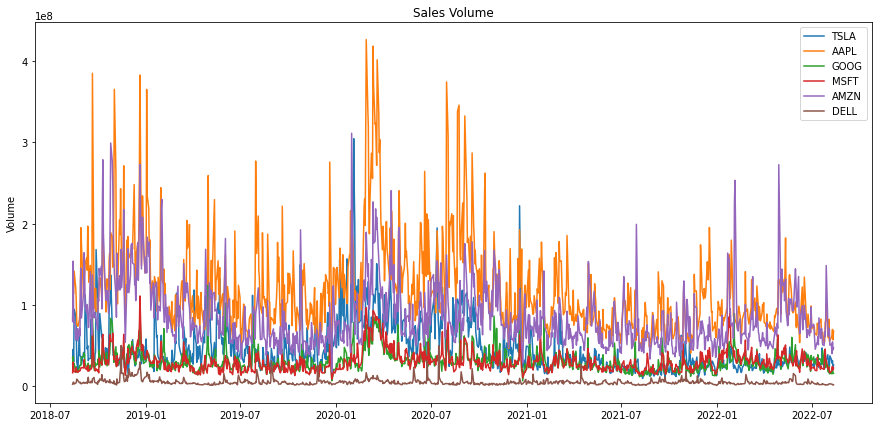

In [8]:
mplot.figure(figsize=(15, 7))
mplot.title(f"Sales Volume")
for i, stock in enumerate(stocks[0:6], 1):
  mplot.plot(stock['Volume'], label = stockTypes[i - 1]) 
  
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show()  

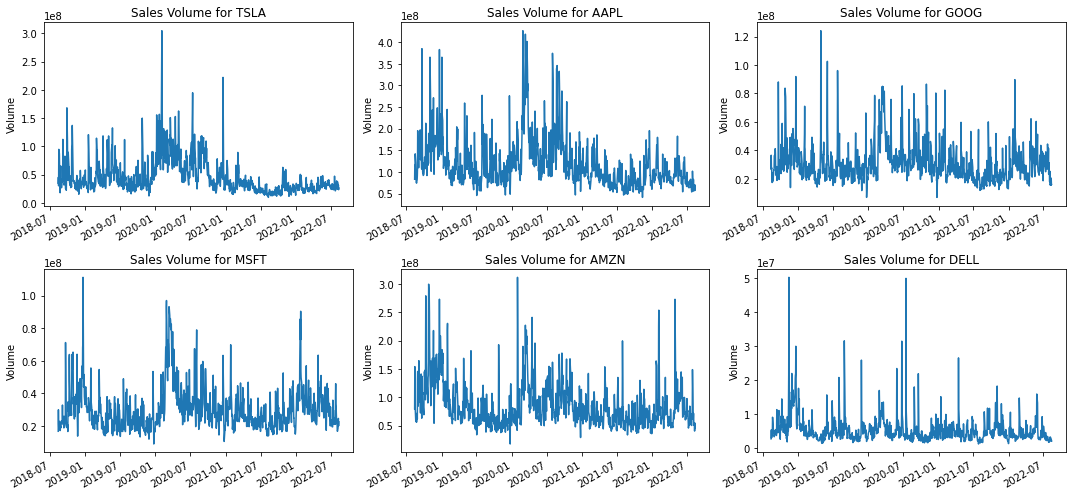

In [9]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

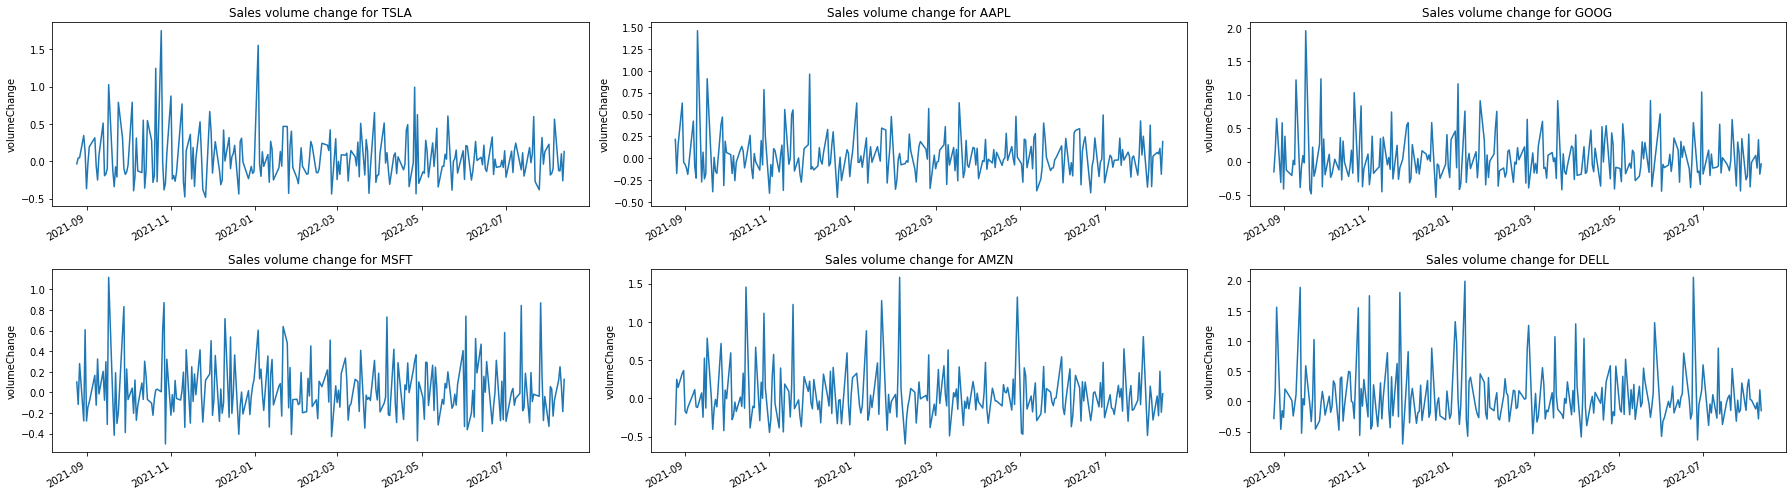

In [10]:
#Volume Change Graphs
mplot.figure(figsize=(25, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks[0:6], 1):
    mplot.subplot(2, 3, i)
    stock['volumeChange'][-244:].plot()
    mplot.ylabel('volumeChange')
    mplot.xlabel(None)
    mplot.title(f"Sales volume change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [11]:
def plotIt(i = 0):
  chart = alt.Chart(stocks[i], title=company_name[i]).mark_bar().encode(
          x='day',
          y='Volume',
          column='month',
          color='year')
  return chart

In [12]:
plotIt(1)

alt.Chart(...)

In [13]:
plotIt(2)

alt.Chart(...)

In [14]:
plotIt(3)

alt.Chart(...)

In [15]:
plotIt(4)

alt.Chart(...)

In [16]:
plotIt(5)

alt.Chart(...)

In [17]:
plotIt(6)

alt.Chart(...)

In [18]:
plotIt(7)

alt.Chart(...)

In [19]:
plotIt(8)

alt.Chart(...)

In [20]:
plotIt(9)

alt.Chart(...)

In [21]:
def plotLines(i = 1, stock = None, yValue='max(Volume)'):
   iV = (alt.Chart(stock, title=company_name[i-1]).transform_filter(datum.month==3).
          mark_line().
          encode(x=alt.X('day', sort=['year', 'month']), y=yValue, color='year').
          properties(height=200  , width=500)) 
   return iV

In [22]:
plotLines(3,stockDf,'max(volumeChange)')

alt.Chart(...)

In [23]:
plotLines(3, stockDf)

alt.Chart(...)

In [24]:
#Get Desired columns to train
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = -100
toRecord = None
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (100, 1).


Open
Date                  
2022-03-23  300.510010
2022-03-24  299.140015
2022-03-25  305.230011
2022-03-28  304.329987

In [25]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [26]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [27]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu' #'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = False

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
13/13 [==============================] - 2s 29ms/step - loss: 0.2506 - val_loss: 0.0720
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2023 - val_loss: 0.0546
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1556 - val_loss: 0.0393
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1172 - val_loss: 0.0269
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0814 - val_loss: 0.0177
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0602 - val_loss: 0.0119
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0095
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0091
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0094
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0094
Epoch 1

In [28]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]

Y_test = Y_test.reshape(s2,s1)
Y_train = Y_train.reshape(s2,s1)

In [29]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 64
X_test: 64
Y_train: 64
Y_test: 64
X Train Shape(64, 1, 5)
Y Train Shape(64, 1)
X Test Shape(64, 1, 5)
Y Test Shape(64, 1)
train_predict: 64
Y_trained_predict: 64
test_predict: 64
Y_test_predict: 64
Shape of Y_train:64
Shape of Y_train:64
Shape of Y_train:64
Shape of Y_train:64


In [30]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
2.604526332326737 

Test RMSE is: 
2.345986894283507


In [31]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

Actual_Y  Predicted_Y
0  304.329995   303.685608
1  313.910016   308.677155
2  313.760006   311.232605
3  313.899996   313.416748
4  309.369990   311.676300

Text(0, 0.5, 'Value of Stock')

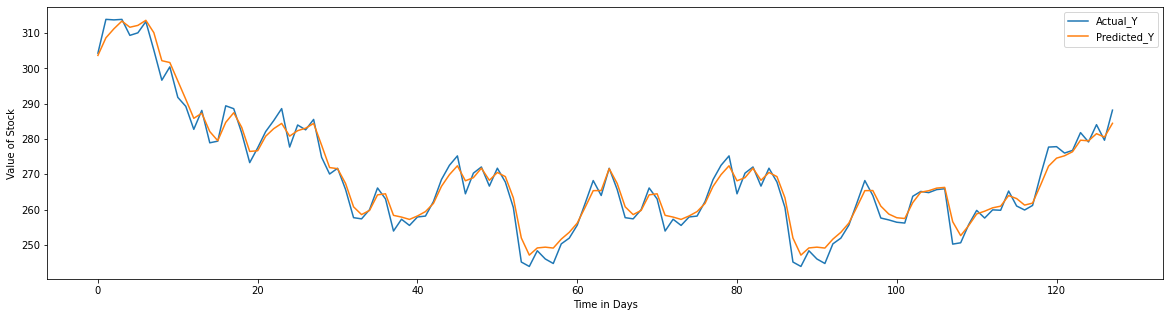

In [32]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [36]:
from pandas.tseries.offsets import BDay

#Prediction Forcastings
predictionCount = 9
lookback =30 
yesterday = end - timedelta(days=1)
trainingStartDate = (end - BDay(lookback)).to_pydatetime()
forcastingTrainingDays = yesterday - trainingStartDate
datelist_future = pd.date_range(end, periods=predictionCount, freq='C').tolist()  
datelist_training = pd.date_range(end=end, periods=lookback, freq='C').tolist() 

y_past_training = model.predict(X_train[-lookback-1:])
print(len(y_past_training))
y_past_training_values = scaler.inverse_transform(y_past_training[0:lookback])
print('y_past_training_values with X_train: ')
print(y_past_training_values[-5:])

y_future_prediction = model.predict(X_train[-predictionCount:])
y_future_prediction_values = scaler.inverse_transform(y_future_prediction)
print('y_future_prediction_values with X_train: ')
y_future_prediction_values1=scaler.inverse_transform(y_future_prediction_values)

print(y_future_prediction_values[:5])
print(len(y_past_training_values))
print(len(datelist_training))

#Look Back prediction
PREDICTIONS_FUTURE = pd.DataFrame(y_future_prediction_values, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_training_values, columns=['Open']).set_index(pd.Series(datelist_training)) 
PREDICTIONS_FUTURE.head(11)

31
y_past_training_values with X_train: 
[[251.60454]
 [253.53545]
 [256.14676]
 [260.67255]
 [265.34442]]
y_future_prediction_values with X_train: 
[[249.10907]
 [249.32791]
 [249.07478]
 [251.60454]
 [253.53545]]
30
30


Open
2022-08-15 16:42:35.342757  249.109070
2022-08-16 16:42:35.342757  249.327911
2022-08-17 16:42:35.342757  249.074783
2022-08-18 16:42:35.342757  251.604538
2022-08-19 16:42:35.342757  253.535446
2022-08-22 16:42:35.342757  256.146759
2022-08-23 16:42:35.342757  260.672546
2022-08-24 16:42:35.342757  265.344421
2022-08-25 16:42:35.342757  265.381836

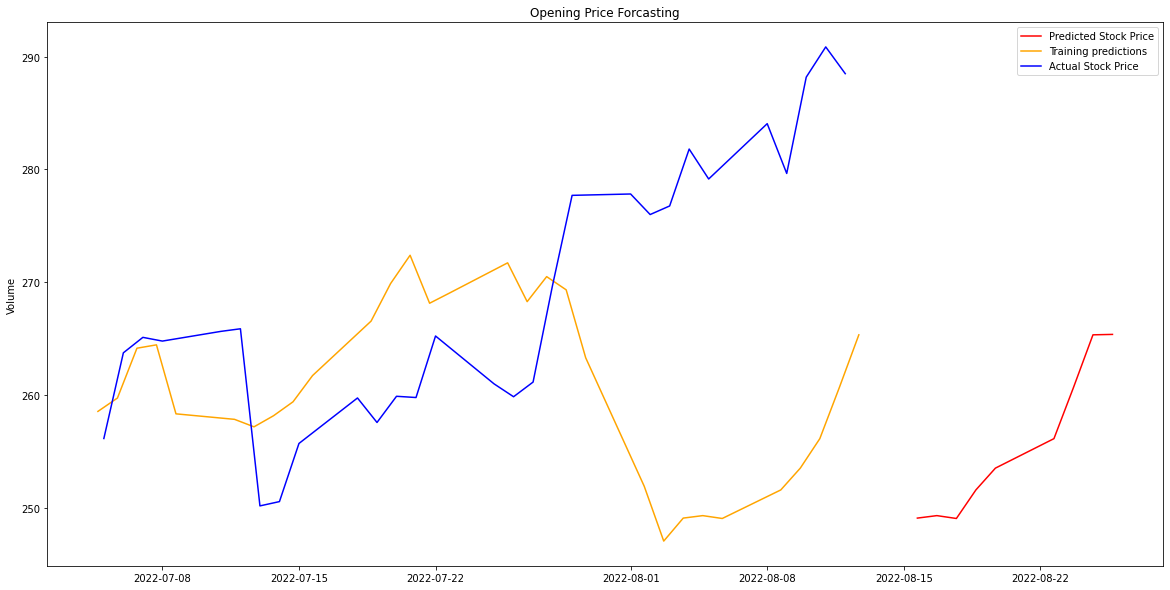

In [37]:
mplot.figure(figsize=(20,10))
mplot.title(f"Opening Price Forcasting")
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[trainingStartDate:].index, PREDICTION_TRAIN.loc[trainingStartDate:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[trainingStartDate:].index, stockDf.loc[trainingStartDate:]['Open'], color='b', label='Actual Stock Price')
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show() 

In [38]:
#Prediction Forcastings take 2- using different sample of data than used above
forcastingDays = 90
lookback =150
trainingStartDate = end - timedelta(days=lookback)
datelist_future = pd.date_range(end, periods=forcastingDays, freq='C').tolist() 
datelist_Training = pd.date_range(end=end, periods=lookback, freq='C').tolist() 

predictMeData = stockDf[-lookback:] 
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')

predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs)  
forcastingTrainingValues = predictionDs[0:lookback,:] 

XX, YY = batchData(forcastingTrainingValues, batchSize, "L")
XX = np.reshape(XX, (XX.shape[0], timeSteps, XX.shape[1]))
forcastingValues = model.predict(XX)

y_future_values = scaler.inverse_transform(forcastingValues)
y_future_values

array([[319.55646],
       [311.3387 ],
       [307.4145 ],
       [307.99496],
       [309.75836],
       [305.0774 ],
       [296.91498],
       [293.41754],
       [301.90744],
       [302.47104],
       [299.81235],
       [303.5787 ],
       [308.84296],
       [308.6298 ],
       [308.67206],
       [304.92163],
       [305.68103],
       [303.84702],
       [307.1799 ],
       [304.9609 ],
       [304.42273],
       [298.09985],
       [299.69345],
       [299.1203 ],
       [297.69727],
       [294.45468],
       [288.21985],
       [289.4413 ],
       [278.37723],
       [287.64725],
       [290.692  ],
       [293.2846 ],
       [291.96725],
       [298.81995],
       [296.54288],
       [290.9289 ],
       [282.0763 ],
       [282.06046],
       [283.47934],
       [285.98117],
       [282.2906 ],
       [280.5136 ],
       [285.27286],
       [289.68732],
       [291.1734 ],
       [294.0659 ],
       [297.20047],
       [298.90137],
       [298.91333],
       [302.11374],


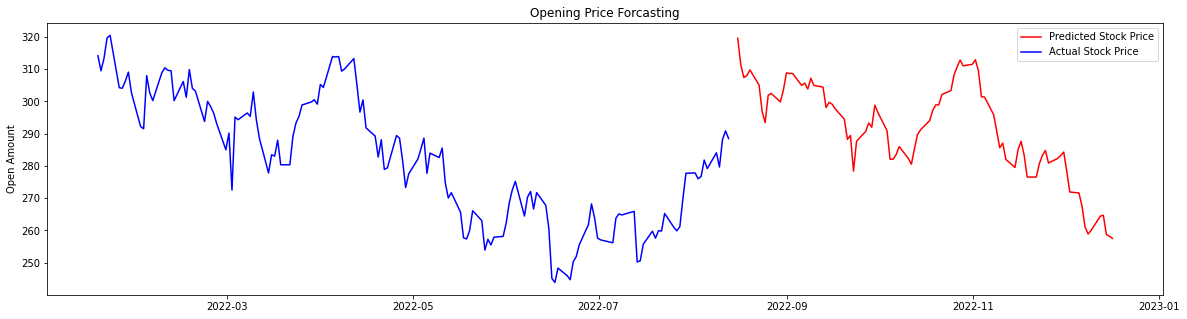

In [39]:
G = stockDf[-lookback:] 
G = predictMeData.to_numpy() 
mplot.figure(figsize=(20,5))
mplot.title(f"Opening Price Forcasting")
mplot.plot(datelist_future, y_future_values[: forcastingDays], color='r', label='Predicted Stock Price') 
mplot.plot(datelist_Training[-lookback:], G, color='b', label='Actual Stock Price')
mplot.ylabel('Open Amount')
mplot.xlabel(None)
mplot.legend()
mplot.show() 

In [40]:
datelist_future

[Timestamp('2022-08-15 16:42:35.342757', freq='C'),
 Timestamp('2022-08-16 16:42:35.342757', freq='C'),
 Timestamp('2022-08-17 16:42:35.342757', freq='C'),
 Timestamp('2022-08-18 16:42:35.342757', freq='C'),
 Timestamp('2022-08-19 16:42:35.342757', freq='C'),
 Timestamp('2022-08-22 16:42:35.342757', freq='C'),
 Timestamp('2022-08-23 16:42:35.342757', freq='C'),
 Timestamp('2022-08-24 16:42:35.342757', freq='C'),
 Timestamp('2022-08-25 16:42:35.342757', freq='C'),
 Timestamp('2022-08-26 16:42:35.342757', freq='C'),
 Timestamp('2022-08-29 16:42:35.342757', freq='C'),
 Timestamp('2022-08-30 16:42:35.342757', freq='C'),
 Timestamp('2022-08-31 16:42:35.342757', freq='C'),
 Timestamp('2022-09-01 16:42:35.342757', freq='C'),
 Timestamp('2022-09-02 16:42:35.342757', freq='C'),
 Timestamp('2022-09-05 16:42:35.342757', freq='C'),
 Timestamp('2022-09-06 16:42:35.342757', freq='C'),
 Timestamp('2022-09-07 16:42:35.342757', freq='C'),
 Timestamp('2022-09-08 16:42:35.342757', freq='C'),
 Timestamp('